 # Probabilistic ICA
  The model we consider is the censored Log-ICA.

In [1]:
import importlib
import numpy as np 
import math, scipy
from scipy.stats import multivariate_normal, geom, logistic
import matplotlib.pyplot as plt
import ica
importlib.reload(ica)

<module 'ica' from '/Users/francescacrucinio/Documents/MD_LVM/ica.py'>

In [2]:
Y = np.loadtxt("censored_ica_data100.txt")

In [3]:
d = Y.shape[0]
ndata = Y.shape[1]
p = 2

In [4]:
Y.shape[1]

100

In [5]:
tmp = np.loadtxt("ica_truth.txt")
true_A = tmp[:d, :]
true_sigma = tmp[d, 0]
alpha = 0.8
a1 = np.abs(np.reshape(true_A[:, 0], [16, 16]))
a2 = np.abs(np.reshape(true_A[:, 1], [16, 16]))

In [6]:
sigma0 = 0
A0 = np.zeros((d, p))
alpha = 0.8

In [7]:
Niter = 3000
multilevel_start = 1
learning_rate_sigma = 0.0000001
learning_rate_A = 0.0001
M = 2
H = 10
p_exp = 1/H

In [8]:
# initialize SAEM
z_iter = np.zeros([Niter, ndata, p])
s1_iter = np.zeros((Niter, p, p))
s2_iter = np.zeros((Niter, d, p))
sigma_iter_saem = np.zeros((Niter))
A_iter_saem = np.zeros((Niter, d, p))

In [9]:
z_past = np.random.binomial(1, alpha, size = ndata*p)*np.random.logistic(scale = 1/2, size = ndata*p)
z_past = np.reshape(z_past, [ndata, p])
A_iter_saem[0,:,:] = A0
sigma_iter_saem[0] = sigma0
n = 1
s1_new = np.zeros((ndata, p, p))
s2_new = np.zeros((ndata, d, p))
for j in range(ndata):
    data = Y[:, j]
    z_iter[n, j, :] = ica.censored_logICA_sample_posterior(z_past[j, :], A_iter_saem[n-1, :, :], sigma_iter_saem[n-1], alpha, data)
    s1_new[j, :, :], s2_new[j, :, :] = ica.logICA_sufficient_statistic(z_iter[n, j, :], data)
s1_iter[n, :, :] = np.mean(s1_new, axis = 0)
s2_iter[n, :, :] = np.mean(s2_new, axis = 0)
A_iter_saem[n, :, :], sigma_iter_saem[n] = ica.logICA_mle(s1_iter[n, :, :], s2_iter[n, :, :], Y)

/Users/francescacrucinio/Documents/MD_LVM/ica.py:63: RuntimeWarning: invalid value encountered in double_scalars
  log_acceptance_ratio = (likelihood_past - likelihood_proposal)/(2*sigma**2)


In [10]:
for n in range(1, Niter-1):
    # SAEM
    delta = 1/n
    s1_new = np.zeros((ndata, p, p))
    s2_new = np.zeros((ndata, d, p))
    for j in range(ndata):
        data = Y[:, j]
        z_iter[n+1, j, :] = ica.censored_logICA_sample_posterior(z_iter[n, j, :], A_iter_saem[n, :, :], sigma_iter_saem[n], alpha, data)
        s1_new[j, :, :], s2_new[j, :, :] = ica.logICA_sufficient_statistic(z_iter[n+1, j, :], data)
    s1_update = np.mean(s1_new, axis = 0)
    s2_update = np.mean(s2_new, axis = 0)
    s1_iter[n+1, :, :] = s1_iter[n, :, :] + delta*(s1_update - s1_iter[n, :, :])
    s2_iter[n+1, :, :] = s2_iter[n, :, :] + delta*(s2_update - s2_iter[n, :, :])
    A_iter_saem[n+1,:,:], sigma_iter_saem[n+1] = ica.logICA_mle(s1_iter[n+1, :], s2_iter[n+1, :], Y)

## Check convergence: $\sigma$

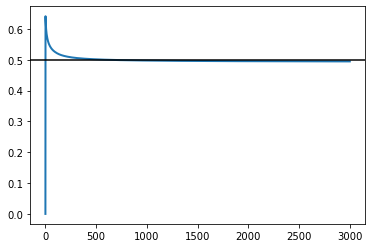

In [11]:
# plt.xscale('log')
# plt.yscale('log')
plt.plot(range(Niter), sigma_iter_saem, label = 'saem', lw = 2)
plt.axhline(true_sigma, c='k')
# legend = plt.legend(loc='center', bbox_to_anchor=(0.5, -0.4), ncol = 4)
# plt.savefig('ica_sigma_convergence.pdf', bbox_inches="tight")

In [12]:
sigma_iter_saem

array([0.        , 0.64134386, 0.628007  , ..., 0.49478958, 0.49478916,
       0.49478875])

## Check convergence: $A$

In [13]:
A_iter_saem_tmp = np.abs(np.reshape(A_iter_saem[:, :, 0], [Niter, 16, 16]))
A_iter_saem_tmp2 = np.abs(np.reshape(A_iter_saem[:, :, 1], [Niter, 16, 16]))

In [14]:
for j in range(Niter):
    A_iter_saem_tmp[j, :, :] = A_iter_saem_tmp[j, :, :]/np.max(A_iter_saem_tmp[j, :, :])
    A_iter_saem_tmp2[j, :, :] = A_iter_saem_tmp2[j, :, :]/np.max(A_iter_saem_tmp2[j, :, :])

/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_21552/468290391.py:2: RuntimeWarning: invalid value encountered in true_divide
  A_iter_saem_tmp[j, :, :] = A_iter_saem_tmp[j, :, :]/np.max(A_iter_saem_tmp[j, :, :])
/var/folders/yb/2yx4lkb90l57vb9ljkzffpq40000gn/T/ipykernel_21552/468290391.py:3: RuntimeWarning: invalid value encountered in true_divide
  A_iter_saem_tmp2[j, :, :] = A_iter_saem_tmp2[j, :, :]/np.max(A_iter_saem_tmp2[j, :, :])


In [15]:
trace_saem = np.trace(A_iter_saem_tmp, axis1 = 1, axis2 = 2)
trace_saem2 = np.trace(A_iter_saem_tmp2, axis1 = 1, axis2 = 2)

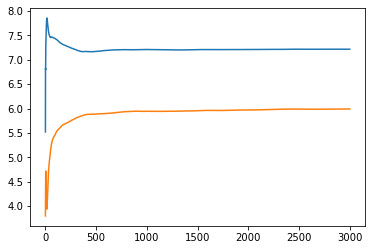

In [16]:
plt.plot(range(Niter), trace_saem, label = 'saem')
plt.plot(range(Niter), trace_saem2, label = 'saem')
# plt.legend(loc='center right', bbox_to_anchor=(1.5, 0))
# plt.savefig('ica_a1_convergence.pdf', bbox_inches="tight")

## Plot results

In [17]:
estimated_a1_saem = np.abs(np.reshape(A_iter_saem[Niter-1, :, 0]/np.max(A_iter_saem[Niter-1, :, 0]), [16, 16]))
estimated_a2_saem = np.abs(np.reshape(A_iter_saem[Niter-1, :, 1]/np.max(A_iter_saem[Niter-1, :, 1]), [16, 16]))

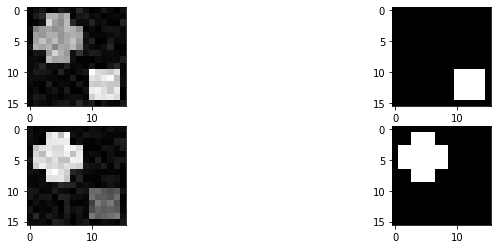

In [18]:
_, axs = plt.subplots(2, 2, figsize = (12, 4))
plt.gray()
axs[0,0].imshow(estimated_a1_saem)
axs[0,1].imshow(a1)
axs[1,0].imshow(estimated_a2_saem)
axs[1,1].imshow(a2)

In [19]:
z_iter[Niter-1,:,:].shape

(100, 2)

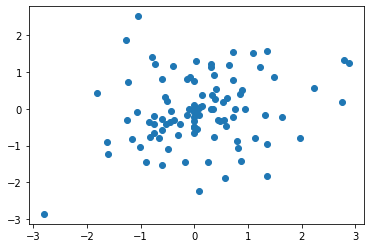

In [20]:
plt.scatter(z_iter[Niter-1,:,0], z_iter[Niter-1,:,1])